In [2]:
# Dependencies
import os
import requests
import pandas as pd
from config import gmaps_key
from pprint import pprint
import gmaps
import matplotlib.pyplot as plt
import imageio
import numpy as np
import math

In [3]:
import scipy.stats as stats

In [4]:
# Import google API key
from config import gmaps_key
# Setup Google Maps API
gmaps.configure(api_key=gmaps_key)

In [5]:
# Combine raw data into a data frame
yrs_15to18_path = os.path.join("data","crash_data_2015-2018.csv")
yrs_19to21_path = os.path.join("data","crash_data_2019-2021.csv")
years_15to18 = pd.read_csv(yrs_15to18_path)
years_19to21 = pd.read_csv(yrs_19to21_path)
crash_df = pd.concat([years_19to21,years_15to18],ignore_index=True)
crash_df.head()

,CRASH_DATE,CRASH_TIME,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,LATITUDE,LONGITUDE
0,1/7/2021,3:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,3,NO INDICATION OF INJURY,0.0,0.0,3,41.924260,-87.753029
1,1/7/2021,0:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,UNABLE TO DETERMINE,N,2,NONINCAPACITATING INJURY,1.0,0.0,0,41.902701,-87.711526
2,1/7/2021,0:26,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,N,3,NO INDICATION OF INJURY,0.0,0.0,0,41.935010,-87.756408
3,1/7/2021,0:07,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,S,1,NONINCAPACITATING INJURY,2.0,0.0,0,41.838327,-87.617613
4,1/6/2021,23:21,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,W,2,NO INDICATION OF INJURY,0.0,0.0,23,41.881926,-87.745462


In [6]:
crash_columns = crash_df.columns
print(crash_columns)

Index(['CRASH_DATE', 'CRASH_TIME', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION',
       'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'CRASH_HOUR', 'LATITUDE', 'LONGITUDE'],
      dtype='object')


#### What impacts crash type the most? - Romi

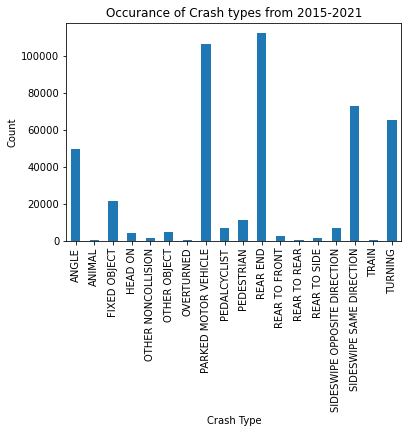

In [8]:
# Create first crash type bar graph
grouped_crashes = crash_df.groupby(["FIRST_CRASH_TYPE"])
crash_count = grouped_crashes["FIRST_CRASH_TYPE"].count()
crash_chart = crash_count.plot(kind='bar')
crash_chart.set_xlabel("Crash Type")
crash_chart.set_ylabel("Count")
crash_chart.set_title("Occurance of Crash types from 2015-2021")
plt.savefig("output_data/crash_type_occurance.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

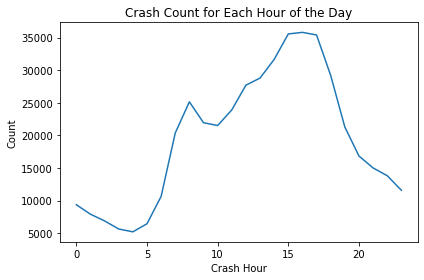

In [9]:
# Create crash count per hour (histogram/line)
crashes_per_hour_grouped = crash_df.groupby(["CRASH_HOUR"])
hour_count = crashes_per_hour_grouped["CRASH_HOUR"].count()
hour_chart_line = hour_count.plot(kind='line')
hour_chart_line.set_xlabel("Crash Hour")
hour_chart_line.set_ylabel("Count")
hour_chart_line.set_title("Crash Count for Each Hour of the Day")
plt.savefig("output_data/crash_per_hour.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

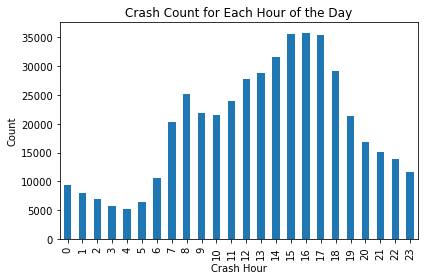

In [10]:
hour_chart_bar = hour_count.plot(kind='bar')
hour_chart_bar.set_xlabel("Crash Hour")
hour_chart_bar.set_ylabel("Count")
hour_chart_bar.set_title("Crash Count for Each Hour of the Day")
plt.savefig("output_data/crash_per_hour_bar.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

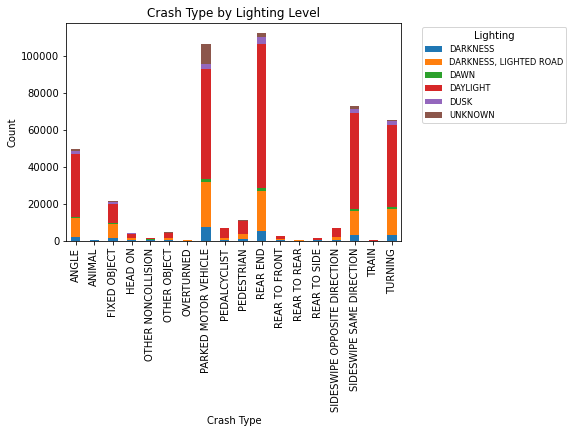

In [11]:
# Create first crash type vs. lighting graph (stacked bar graph)
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

lighting_crash_plot = crash_df.groupby(['FIRST_CRASH_TYPE', 'LIGHTING_CONDITION']).size().unstack().plot(kind='bar', stacked=True)
#fig = plt.figure()
#ax = plt.subplot(111)
plt.title("Crash Type by Lighting Level")
plt.ylabel("Count")
plt.xlabel("Crash Type")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', prop=fontP, title="Lighting")
plt.savefig("output_data/crash_lighting.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

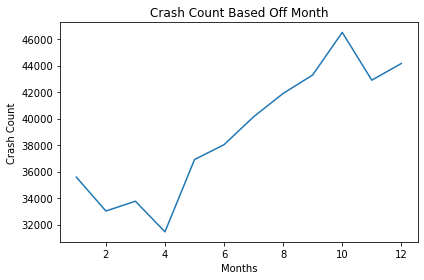

In [12]:
# Create hit and run vs month (line) -analysis correlation to holidays
new_crash_df = crash_df
new_crash_df['Month'] = pd.DatetimeIndex(new_crash_df['CRASH_DATE']).month
month_grouped = new_crash_df.groupby(["Month"])
month_count = month_grouped["Month"].count()
month_chart = month_count.plot(kind='line')
month_chart.set_xlabel("Months")
month_chart.set_ylabel("Crash Count")
month_chart.set_title("Crash Count Based Off Month")
plt.savefig("output_data/crash_month.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

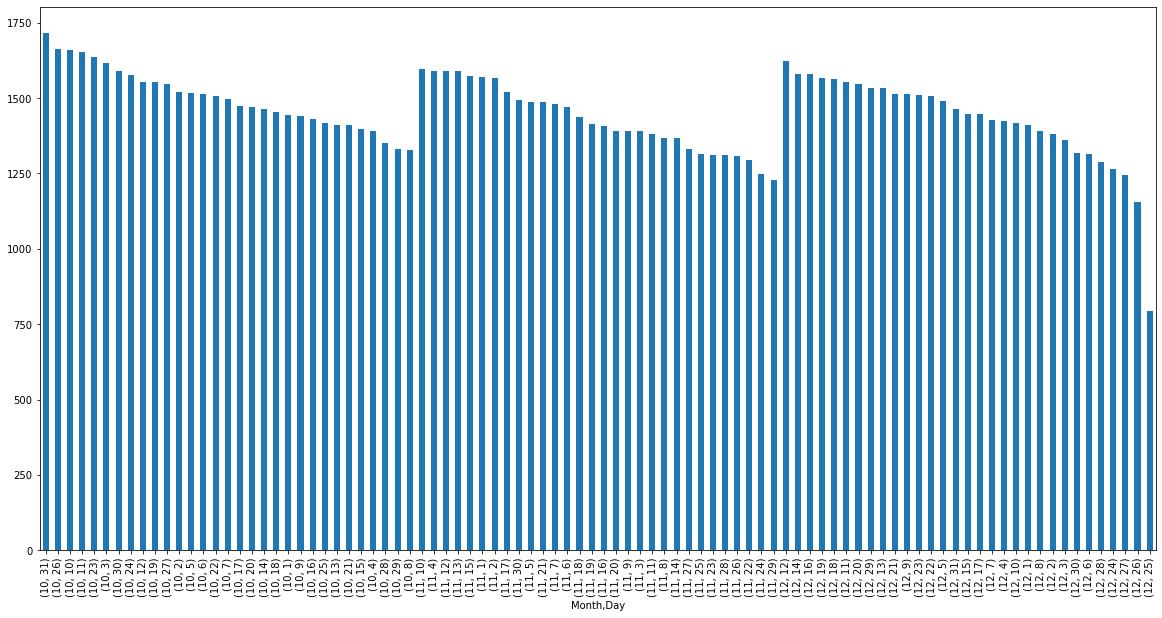

In [13]:
# doesn't necessarily coincide with holidays. Maybe weather?
new_crash_df['Day'] = pd.DatetimeIndex(new_crash_df['CRASH_DATE']).day
holiday_df = new_crash_df.loc[new_crash_df['Month']>9, :]
month_group = holiday_df.groupby('Month')
day_counts = month_group['Day'].value_counts()
day_counts.plot.bar(figsize=(20,10))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

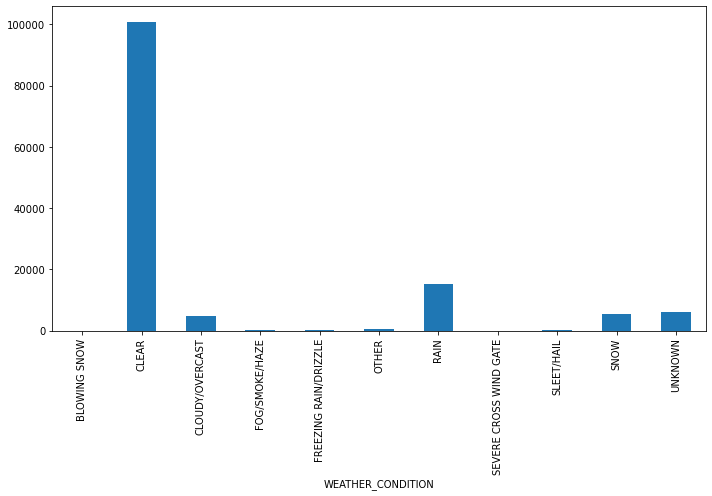

In [14]:
weather_group = holiday_df.groupby('WEATHER_CONDITION')
wrecks_by_weather = weather_group['CRASH_DATE'].count()
wrecks_by_weather.plot.bar(figsize = (10, 7))
plt.tight_layout()

plt.plot

#### What type of injuries are caused by what types of crashes? - Jonathan

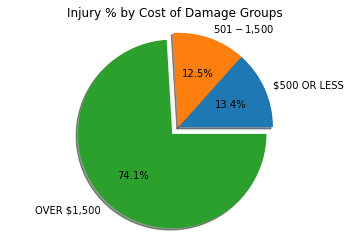

In [15]:
# Create cost of damage and injury count (pie chart)
damage_group = crash_df.groupby("DAMAGE")
injury_count = damage_group["INJURIES_TOTAL"].sum()
damage_inj_df = pd.DataFrame(injury_count)                            

#damage_inj_df

labels = list(damage_inj_df.index.values)
injuries = damage_inj_df["INJURIES_TOTAL"]
explode = (0,0,0.1)
#print(damage_inj_df.index)

plt.pie(injuries, labels=labels, autopct="%1.1f%%", shadow=True, explode=explode)
plt.title("Injury % by Cost of Damage Groups")
plt.axis('equal')
#plt.xlabel("Cost of Damage")
#plt.ylabel("Injury Count")
plt.savefig("output_data/injuries_by_cost_of_damage_group.png")

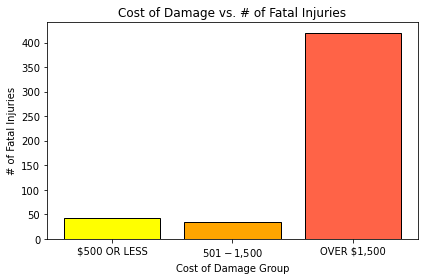

In [16]:
# Create cost of damage and fatal injury count (bar)
fatal_count = damage_group["INJURIES_FATAL"].sum()
damages_fatal_df = pd.DataFrame(fatal_count)

#print(damages_fatal_df)
x_labels = list(damage_inj_df.index.values)
y_values = fatal_count

plt.bar(x_labels, y_values, color=["yellow", "orange", "tomato"], edgecolor="black")
plt.title("Cost of Damage vs. # of Fatal Injuries")
plt.xlabel("Cost of Damage Group")
plt.ylabel("# of Fatal Injuries")

plt.tight_layout()
plt.savefig("output_data/cost_of_damage_vs_fatalities.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

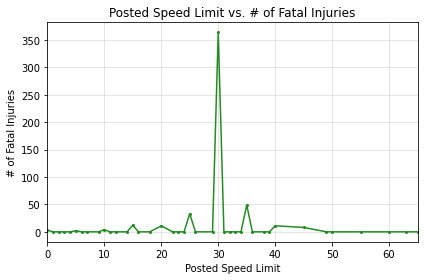

In [17]:
# Create speed vs. fatality count (bar)
# Create cost of damage and fatal injury count (scatter with regression)
speed_group = crash_df.groupby("POSTED_SPEED_LIMIT")
speed_count = speed_group["INJURIES_FATAL"].sum()
speed_fatal_df = pd.DataFrame(speed_count)

#print(damages_fatal_df)
x_labels = list(speed_fatal_df.index.values)
y_values = speed_count

plt.plot(x_labels, y_values, marker="o", markersize=2, color="forestgreen")
#color=["yellow", "cyan", "navy"], edgecolor="black") replace with everything after
# values if wanting to change back to plt.bar

plt.title("Posted Speed Limit vs. # of Fatal Injuries")
plt.xlabel("Posted Speed Limit")
plt.ylabel("# of Fatal Injuries")
plt.xlim(0, 65)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("output_data/speed_limit_vs_fatalities.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()

#### What types of wrecks occur based off location? - Bankston

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

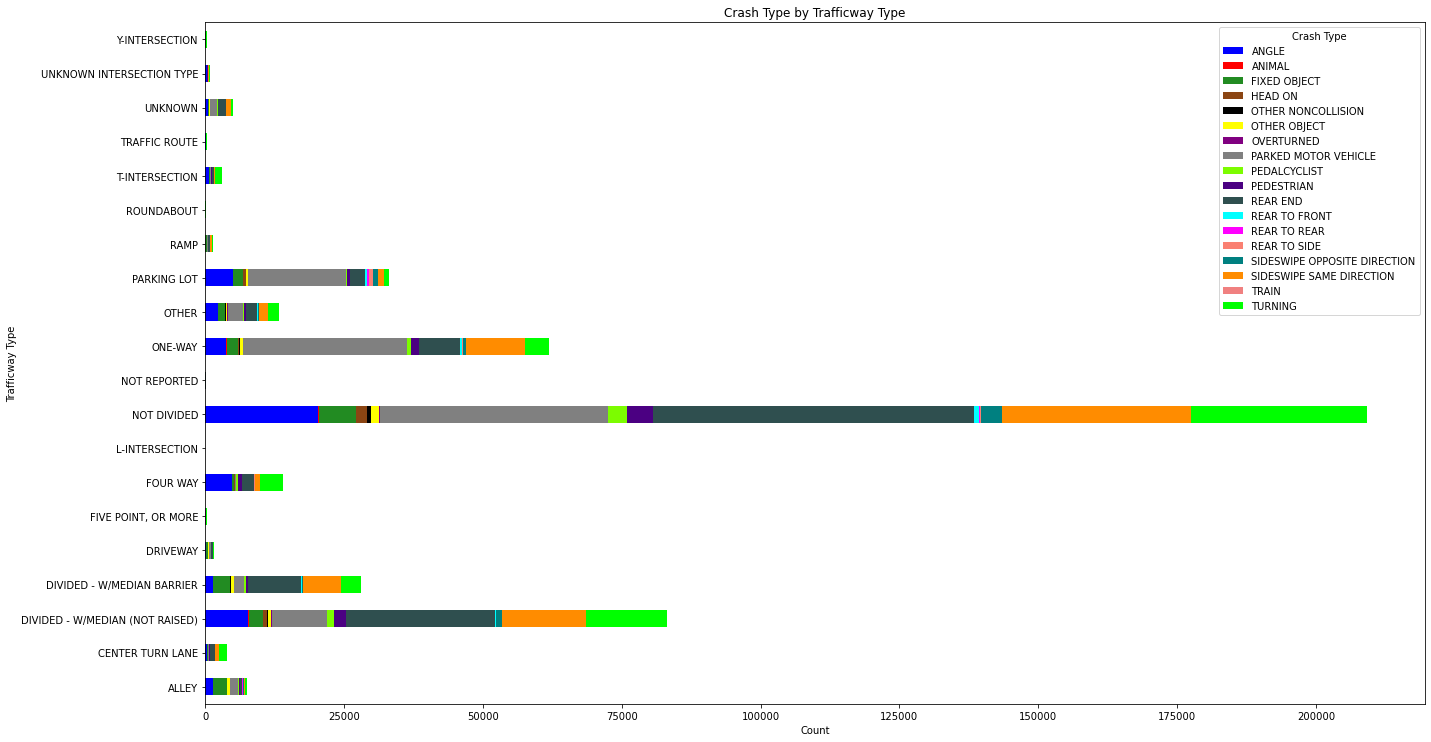

In [18]:
# Create bar graph for trafficway_type
# Need to possibly resize or breakup bars into groups
trafficway_crash_group = crash_df.groupby(['TRAFFICWAY_TYPE', 'FIRST_CRASH_TYPE']).size().unstack()
trafficway_crash_group.plot.barh(stacked = True, figsize = (20, 10), color=['blue', 'red', 'forestgreen', 'saddlebrown', 'black', 'yellow', 'purple', 'gray', 'lawngreen', 'indigo', 'darkslategray', 'aqua', 'fuchsia', 'salmon', 'teal', 'darkorange', 'lightcoral', 'lime'])
plt.tight_layout()
plt.title("Number of Crashes per Type of Crash and Trafficway Type")
plt.xlabel("# of Crashes")
plt.ylabel("Trafficway Type")
plt.savefig("output_data/crashes_per_crashType_and_trafficway.png", bbox_inches = 'tight', pad_inches=0.5)
plt.plot

# Analysis of above: Lack of barriers seem to go with more crashes. Crashes are mostly rear-ending and sideswipe in the same direction

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

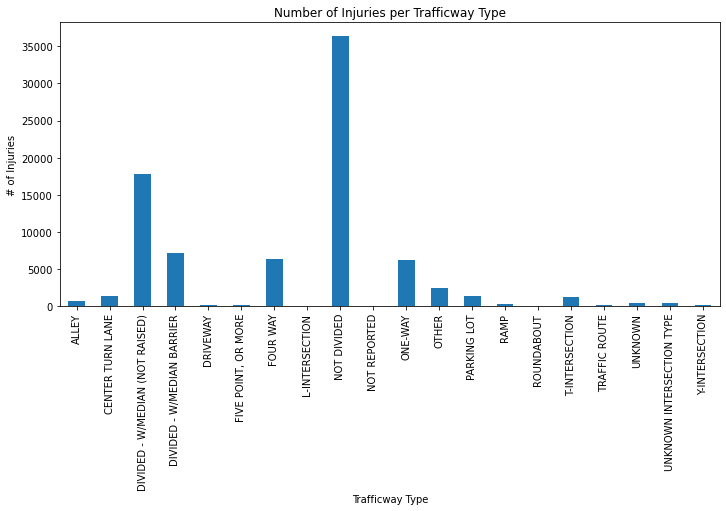

In [19]:
# Create bar graph for trafficway_type and injuries as subplots or separate plots
injuries_trafficway = pd.DataFrame({})
trafficway_group = crash_df.groupby('TRAFFICWAY_TYPE')
injuries_trafficway['INJURIES_TOTAL'] = trafficway_group['INJURIES_TOTAL'].sum()
injuries_trafficway['INJURIES_FATAL'] = trafficway_group['INJURIES_FATAL'].sum()
injuries_trafficway['INJURIES_TOTAL'].plot.bar(figsize = (10, 7))
plt.tight_layout()
plt.title("Number of Injuries per Trafficway Type")
plt.xlabel("Trafficway Type")
plt.ylabel("# of Injuries")
plt.savefig("output_data/injuries_per_trafficway.png", bbox_inches = 'tight', pad_inches=0.5)
plt.plot

In [20]:
injuries_trafficway['PERCENT_FATAL'] = (injuries_trafficway['INJURIES_FATAL']/injuries_trafficway['INJURIES_TOTAL'])*100
injuries_trafficway['PERCENT_INJURY_CRASH'] = (trafficway_group['INJURIES_TOTAL'].sum()/trafficway_group['INJURIES_TOTAL'].count())*100
injuries_trafficway

,INJURIES_TOTAL,INJURIES_FATAL,PERCENT_FATAL,PERCENT_INJURY_CRASH
TRAFFICWAY_TYPE,,,,
ALLEY,731.0,6.0,0.820793,9.659091
CENTER TURN LANE,1274.0,9.0,0.706436,31.636454
DIVIDED - W/MEDIAN (NOT RAISED),17759.0,101.0,0.568726,21.395870
DIVIDED - W/MEDIAN BARRIER,7099.0,63.0,0.887449,25.348140
DRIVEWAY,169.0,1.0,0.591716,10.393604
"FIVE POINT, OR MORE",133.0,2.0,1.503759,37.464789
FOUR WAY,6289.0,36.0,0.572428,45.030789
L-INTERSECTION,12.0,0.0,0.000000,24.489796
NOT DIVIDED,36428.0,184.0,0.505106,17.445023


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

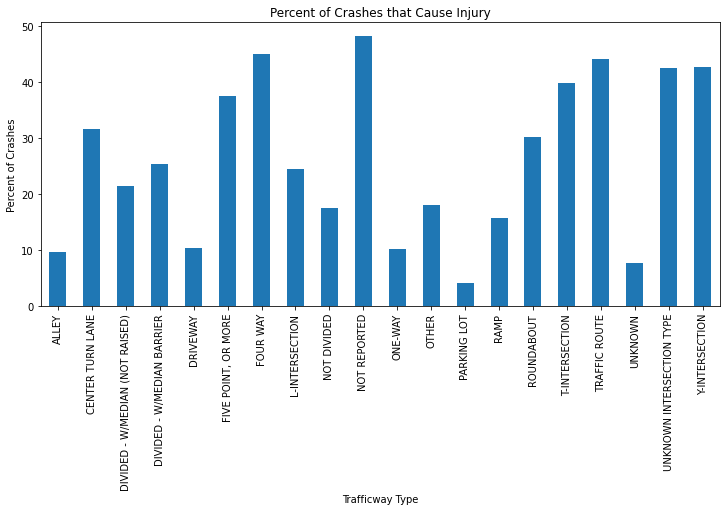

In [21]:
injuries_trafficway['PERCENT_INJURY_CRASH'].plot.bar(figsize = (10, 7))
plt.tight_layout()
plt.title("Percent of Crashes that Cause Injury")
plt.xlabel("Trafficway Type")
plt.ylabel("Percent of Crashes")
plt.savefig("output_data/injuries_per_crash.png", bbox_inches = 'tight', pad_inches=1)
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

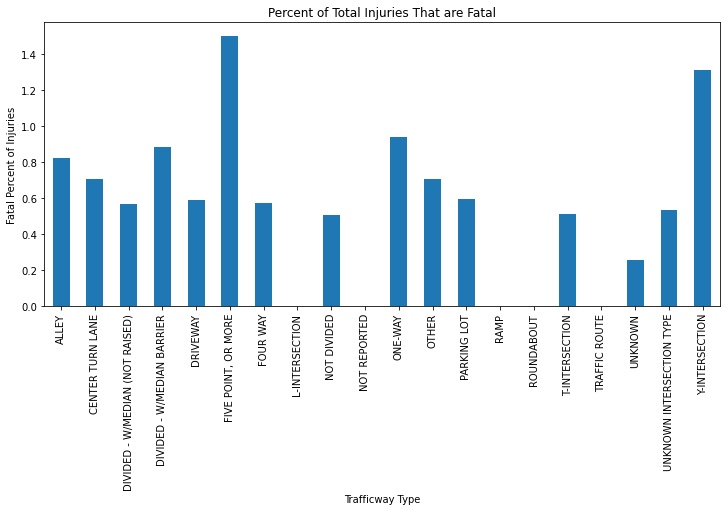

In [22]:
injuries_trafficway['PERCENT_FATAL'].plot.bar(figsize = (10, 7))
plt.tight_layout()
plt.title("Percent of Total Injuries That are Fatal")
plt.xlabel("Trafficway Type")
plt.ylabel("Fatal Percent of Injuries")
plt.savefig("output_data/fatal_per_injuries.png", bbox_inches = 'tight', pad_inches=1)
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

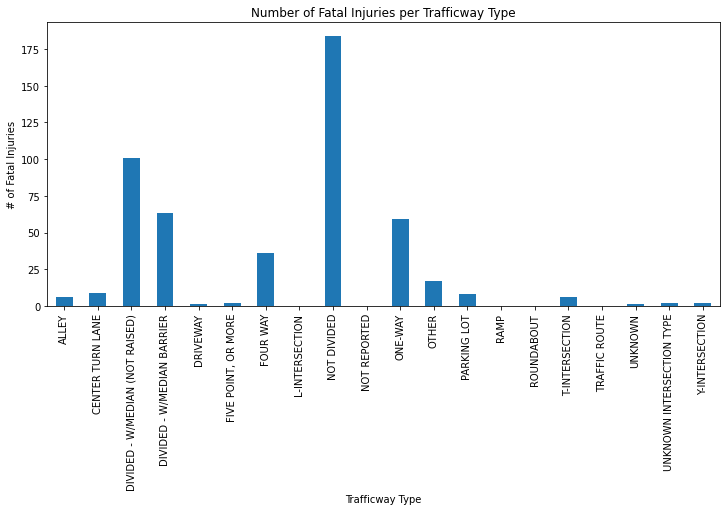

In [23]:
injuries_trafficway['INJURIES_FATAL'].plot.bar(figsize = (10, 7))
plt.tight_layout()
plt.title("Number of Fatal Injuries per Trafficway Type")
plt.xlabel("Trafficway Type")
plt.ylabel("# of Fatal Injuries")
plt.savefig("output_data/fatal_per_trafficway.png", bbox_inches = 'tight', pad_inches=1)
plt.plot

In [24]:
# Remove non-applicable coordinates (NaN and outside city limits) & include injury data
locdata = crash_df.loc[(crash_df["LATITUDE"] >= 41) & \
                                  (crash_df["LATITUDE"] <= 43) & \
                                  (crash_df["LONGITUDE"] >= -88) & \
                                  (crash_df["LONGITUDE"] <= -87), ["LATITUDE","LONGITUDE","INJURIES_TOTAL","INJURIES_FATAL", "TRAFFICWAY_TYPE"]]

In [25]:
# assign coordinates to sections in 10x10 geographical grid 
sections = 10
locdata["LAT_BIN"] = pd.qcut(locdata["LATITUDE"], sections, labels=False) + 1
locdata["LNG_BIN"] = pd.qcut(locdata["LONGITUDE"], sections, labels=False) + 1
locdata["BOX_NUM"] = locdata["LNG_BIN"] + (sections * (locdata["LAT_BIN"]-1))
locdata.head()

,LATITUDE,LONGITUDE,INJURIES_TOTAL,INJURIES_FATAL,TRAFFICWAY_TYPE,LAT_BIN,LNG_BIN,BOX_NUM
0,41.924260,-87.753029,0.0,0.0,DIVIDED - W/MEDIAN (NOT RAISED),8,2,72
1,41.902701,-87.711526,1.0,0.0,FOUR WAY,7,3,63
2,41.935010,-87.756408,0.0,0.0,FOUR WAY,8,2,72
3,41.838327,-87.617613,2.0,0.0,DIVIDED - W/MEDIAN BARRIER,4,9,39
4,41.881926,-87.745462,0.0,0.0,FOUR WAY,6,2,52


In [26]:
# create new dataframe with total injuries per box
injury_per_box = pd.DataFrame({})
box_group = locdata.groupby('BOX_NUM')
injury_per_box['INJURIES_TOTAL'] = box_group['INJURIES_TOTAL'].sum()
injury_per_box['INJURIES_FATAL'] = box_group['INJURIES_FATAL'].sum()
injury_per_box

,INJURIES_TOTAL,INJURIES_FATAL
BOX_NUM,,
2,64.0,2.0
3,262.0,1.0
4,273.0,5.0
5,581.0,3.0
6,968.0,6.0
...,...,...
93,406.0,2.0
94,1035.0,3.0
95,901.0,2.0


In [27]:
# generate coordinate for each square based on the average latitude and longitude of all crashes in that square
injury_per_box["LAT"] = ""
injury_per_box["LNG"] = ""
for box in list(injury_per_box.index):
    box_df = locdata.loc[locdata["BOX_NUM"] == box,["LATITUDE","LONGITUDE"]]
    injury_per_box.loc[box,"LAT"] = box_df["LATITUDE"].mean()
    injury_per_box.loc[box,"LNG"] = box_df["LONGITUDE"].mean()
injury_per_box.sort_values('INJURIES_FATAL', ascending = False)

,INJURIES_TOTAL,INJURIES_FATAL,LAT,LNG
BOX_NUM,,,,
10,3242.0,37.0,41.7122,-87.5744
20,3858.0,28.0,41.7564,-87.5839
30,1931.0,16.0,41.7831,-87.5907
52,2001.0,15.0,41.8821,-87.7446
17,1210.0,13.0,41.7559,-87.6482
...,...,...,...,...
31,6.0,0.0,41.7999,-87.7667
70,18.0,0.0,41.8922,-87.6105
50,3.0,0.0,41.8643,-87.6097


In [28]:
# Create heat map for total injuries by location
fig_lat = locdata["LATITUDE"].median()
fig_lng = locdata["LONGITUDE"].median()
fig = gmaps.figure(layout={"height":"900px","width":"600px"},center=(fig_lat, fig_lng),zoom_level=11)
box_coordinates = injury_per_box[["LAT","LNG"]]
intensity = injury_per_box["INJURIES_TOTAL"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='900px', width='600px'))

In [29]:
# Narrow dataframe to injuries in box 10 (most fatal)
injury_box10 = pd.DataFrame(locdata.loc[locdata['BOX_NUM'] == 10, :])
# duplicate crash locations
duplicate_box10 = injury_box10[injury_box10.duplicated(['LATITUDE', 'LONGITUDE'], keep = False)]
duplicate_box10.sort_values(['LATITUDE', 'LONGITUDE'])

,LATITUDE,LONGITUDE,INJURIES_TOTAL,INJURIES_FATAL,TRAFFICWAY_TYPE,LAT_BIN,LNG_BIN,BOX_NUM
14650,41.644670,-87.540095,0.0,0.0,DIVIDED - W/MEDIAN BARRIER,1,10,10
94534,41.644670,-87.540095,0.0,0.0,UNKNOWN,1,10,10
186322,41.644670,-87.540095,0.0,0.0,OTHER,1,10,10
218368,41.644670,-87.540095,0.0,0.0,PARKING LOT,1,10,10
284739,41.644670,-87.540095,0.0,0.0,NOT DIVIDED,1,10,10
...,...,...,...,...,...,...,...,...
453491,41.740177,-87.605070,0.0,0.0,NOT DIVIDED,1,10,10
464101,41.740177,-87.605070,0.0,0.0,NOT DIVIDED,1,10,10
464217,41.740177,-87.605070,0.0,0.0,PARKING LOT,1,10,10
371766,41.740182,-87.604777,0.0,0.0,NOT DIVIDED,1,10,10


In [30]:
# Create heat map for fatal injuries by location
intensity = injury_per_box["INJURIES_FATAL"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='900px', width='600px'))

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

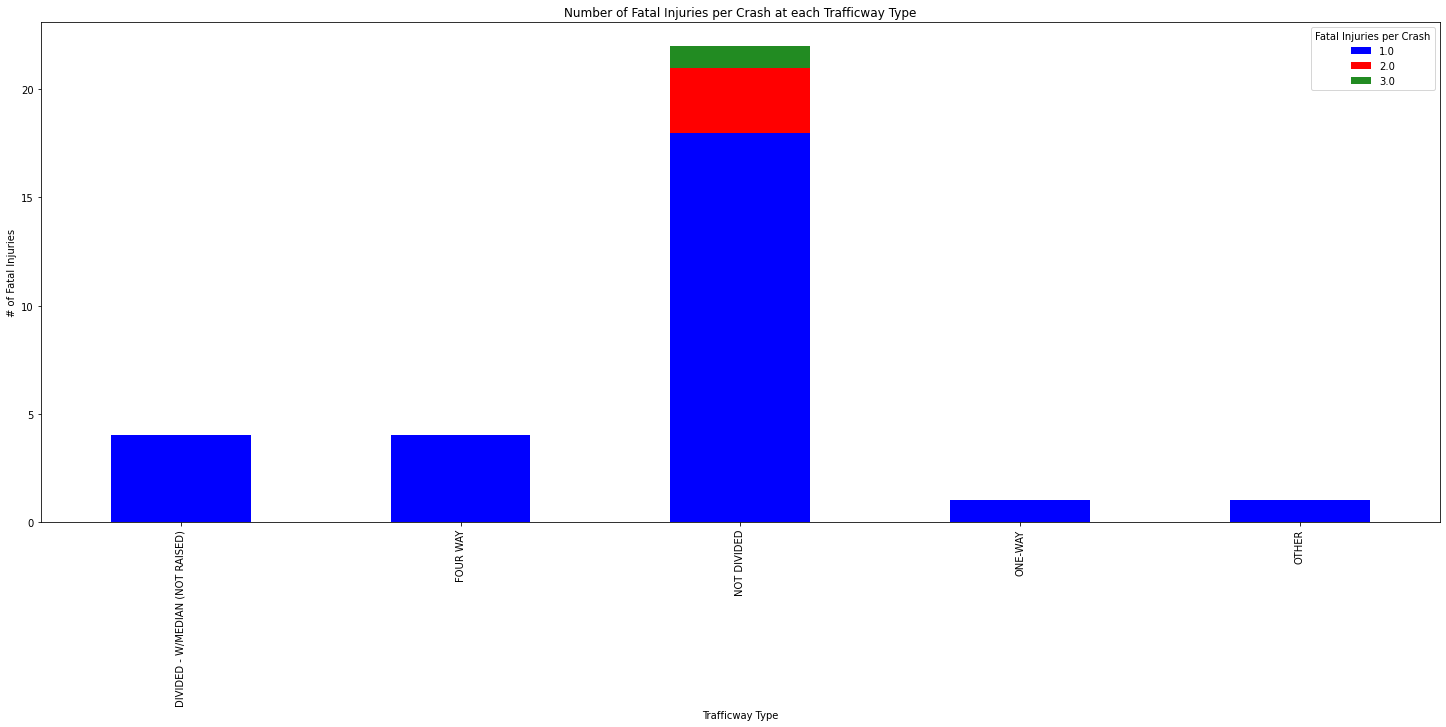

In [31]:
fatal_box10 = injury_box10.loc[injury_box10['INJURIES_FATAL'] > 0, :]
trafficway_box10 = fatal_box10.groupby(['TRAFFICWAY_TYPE', 'INJURIES_FATAL']).size().unstack()
trafficway_box10.plot.bar(stacked = True, figsize = (20, 10), color=['blue', 'red', 'forestgreen', 'saddlebrown', 'black', 'yellow', 'purple', 'gray', 'lawngreen', 'indigo', 'darkslategray', 'aqua', 'fuchsia', 'salmon', 'teal', 'darkorange', 'lightcoral', 'lime'])
plt.tight_layout()
plt.title("Number of Fatal Injuries per Crash at each Trafficway Type")
plt.xlabel("Trafficway Type")
plt.ylabel("# of Fatal Injuries")
plt.legend(title="Fatal Injuries per Crash")
plt.savefig("output_data/fatal_per_trafficway_box10.png", bbox_inches = 'tight', pad_inches=1)
plt.plot

#### Create heat map of crashes by location with location of high schools plotted - Baker

In [32]:
# get counts of each box to be used as intensities in the heat map
crash_per_box = pd.DataFrame({})
crash_per_box["COUNT"] = locdata["BOX_NUM"].value_counts().sort_index()
crash_per_box

,COUNT
2,336
3,1498
4,1605
5,3455
6,5232
...,...
93,3105
94,8341
95,8098
96,10048


In [33]:
# generate coordinate for each square based on the average latitude and longitude of all crashes in that square
crash_per_box["LAT"] = ""
crash_per_box["LNG"] = ""
for box in list(crash_per_box.index):
    box_df = locdata.loc[locdata["BOX_NUM"] == box,["LATITUDE","LONGITUDE"]]
    crash_per_box.loc[box,"LAT"] = box_df["LATITUDE"].mean()
    crash_per_box.loc[box,"LNG"] = box_df["LONGITUDE"].mean()
crash_per_box

,COUNT,LAT,LNG
2,336,41.7216,-87.738
3,1498,41.7104,-87.7188
4,1605,41.7054,-87.7009
5,3455,41.7081,-87.6811
6,5232,41.7094,-87.6641
...,...,...,...
93,3105,41.9836,-87.7175
94,8341,41.9938,-87.6992
95,8098,41.997,-87.6825
96,10048,41.9926,-87.6652


In [34]:
# Generate heat map using the BOX_COORD as the coordinates and crash_per_box as the intensity
box_coordinates = crash_per_box[["LAT","LNG"]]
intensity = crash_per_box["COUNT"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig1.add_layer(heat_layer)

NameError: name 'fig1' is not defined

In [63]:
# Get center coordinates of data and call google api for high schools in the area
center = f"{locdata['LATITUDE'].mean()},{locdata['LONGITUDE'].mean()}"

In [64]:
# Call google api for high schools within 30000 meters (~18 miles)
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
params = {
    "key": gmaps_key,
    "query": "high school",
    "location": center,
    "radius": "30000"
}
response = requests.get(base_url,params=params).json()

In [65]:
# Store high school data
results = response["results"]
schools_df = pd.DataFrame({})
schools_df["name"] = [results[i]["name"] for i in range(len(results))]
schools_df["lat"] = [results[i]["geometry"]["location"]["lat"] for i in range(len(results))]
schools_df["lng"] = [results[i]["geometry"]["location"]["lng"] for i in range(len(results))]
schools_df["address"] = [results[i]["formatted_address"][:-len(", United States")] for i in range(len(results))]

In [66]:
# Plot location of high schools
school_coordinates = schools_df[["lat","lng"]].astype(float)
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Address</dt><dd>{address}</dd>
</dl>
"""
school_info = [info_box_template.format(**row) for index, row in schools_df.iterrows()]
markers = gmaps.marker_layer(school_coordinates, info_box_content=school_info)
fig1.add_layer(markers)
fig1

Figure(layout=FigureLayout(height='900px', width='600px'))

#### What weird connections can we make?

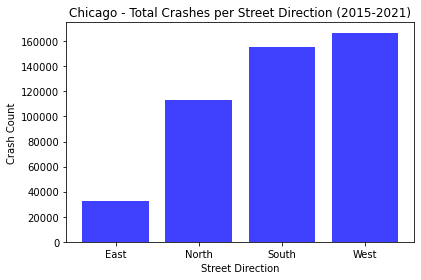

In [67]:
# Create direction facing bar graph (NSEW)
dir_values = crash_df.groupby(["STREET_DIRECTION"])["STREET_DIRECTION"].count()
# get the index for the x-axis but change the initials to the full cardinal direction (W => West)
x = ["East", "North", "South", "West"]
y = dir_values.values
plt.bar(x, y, color='blue', alpha =.75, align='center')
plt.title("Chicago - Total Crashes per Street Direction (2015-2021)")
plt.xlabel("Street Direction")
plt.ylabel("Crash Count")

plt.tight_layout()
plt.savefig("output_data/total_crashes_per_st_dir.png")
plt.show()

In [68]:
sub_df = crash_df.loc[crash_df["CRASH_HOUR"] == 0, ["CRASH_HOUR","STREET_DIRECTION"]]
sub_df

,CRASH_HOUR,STREET_DIRECTION
1,0,N
2,0,N
3,0,S
146,0,W
147,0,S
...,...,...
467111,0,W
467251,0,S
467305,0,W
467417,0,W


In [69]:
# format the time for the title of each slide in the gif
def formatHour(h_num):
    if h_num < 12:
        ampm = "AM"
    else:
        ampm = "PM"
        h_num -= 12
    if h_num == 0:
        h_num = 12
    return f"{h_num}{ampm}"

In [70]:
# generate the color for each slide in the gif -- black to yellow to black (signifies night to day to night)
def generateColor(h_num):
    col_eq = (-.5 * math.cos(h_num/4)) + .5
    r = col_eq
    g = col_eq * (241/255)
    b = col_eq * (31/255)
    return (r,g,b)

In [71]:
# Create gif of street direction crash data over time
# Gif creation resource: https://ndres.me/post/matplotlib-animated-gifs-easily/
def plotDirectionsOverTime(df,h):
    sub_df = df.loc[df["CRASH_HOUR"] == h, ["STREET_DIRECTION"]]
    y = sub_df.groupby(["STREET_DIRECTION"])["STREET_DIRECTION"].count()
    x = ["East", "North", "South", "West"]
    fig2, ax2 = plt.subplots(figsize=(16,9))
    ax2.bar(x,y,color=generateColor(h))
    formatted_h = formatHour(h)
    ax2.set(xlabel="Street Direction", \
            ylabel="Crash Count", \
            title="Chicago - Crashes per Street Direction at {}".format(formatted_h))
    ax2.set_ylim(0, 13000)
    fig2.canvas.draw()
    image = np.frombuffer(fig2.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig2.canvas.get_width_height()[::-1] + (3,))
    return image

<ipython-input-71-dc38c58e5c4d>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots(figsize=(16,9))


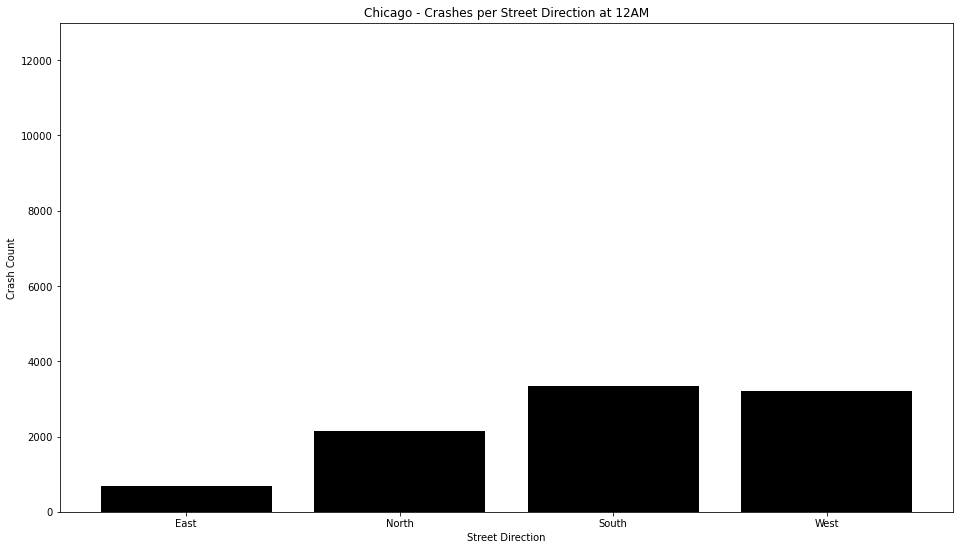

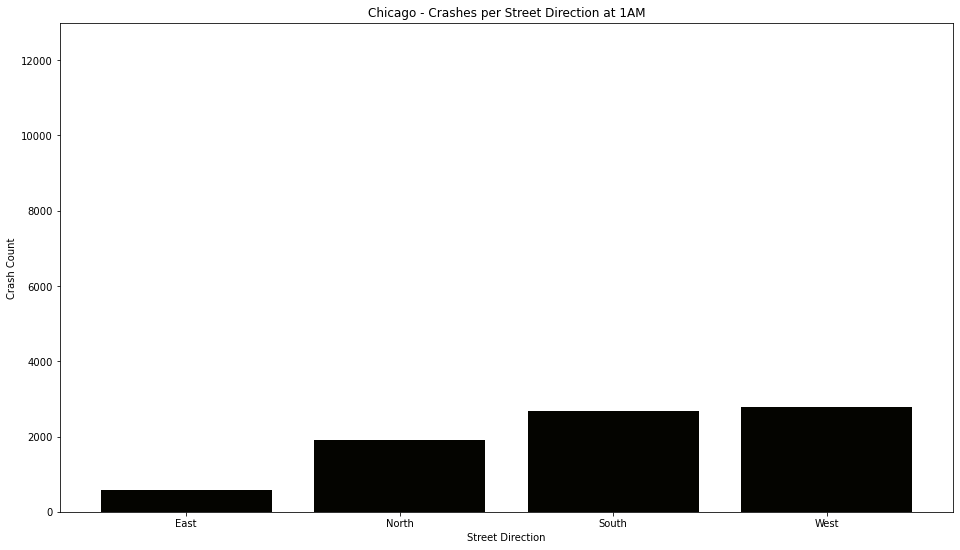

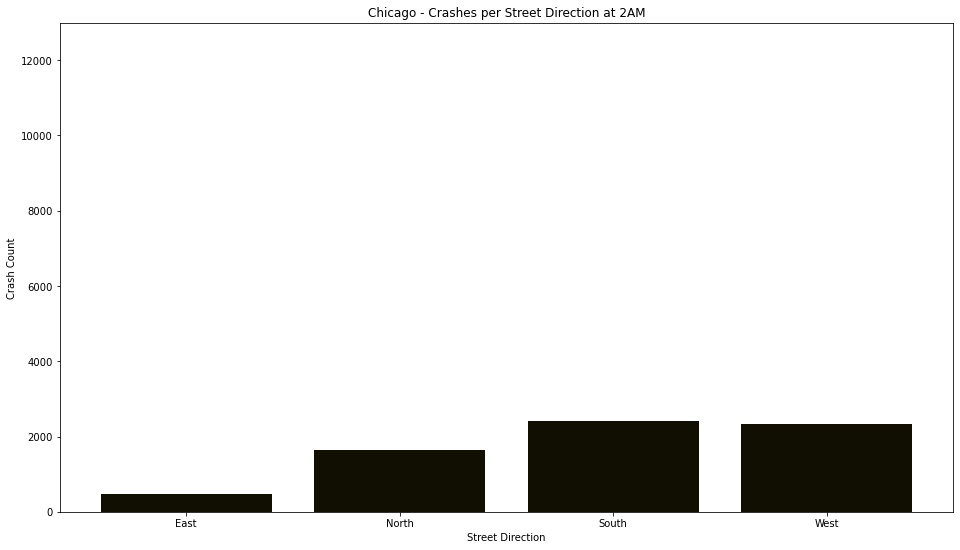

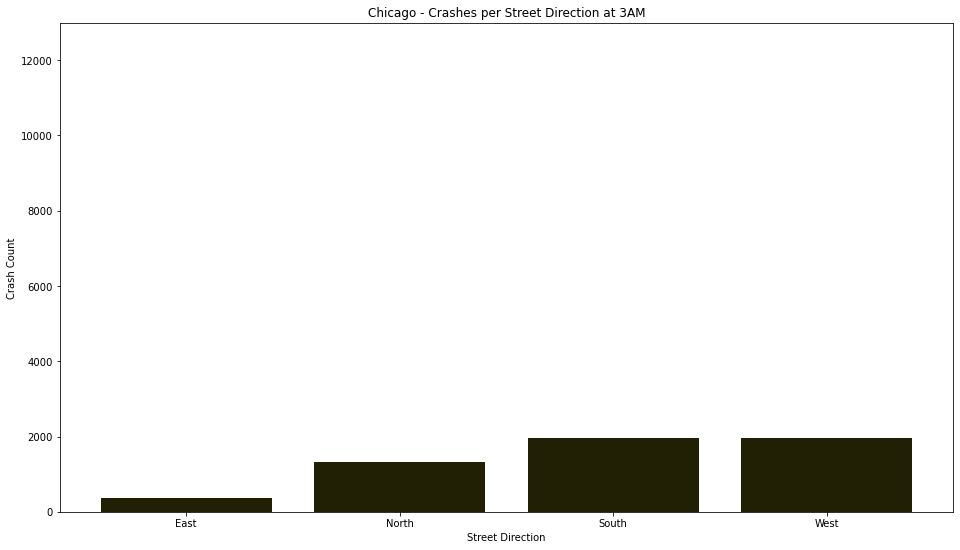

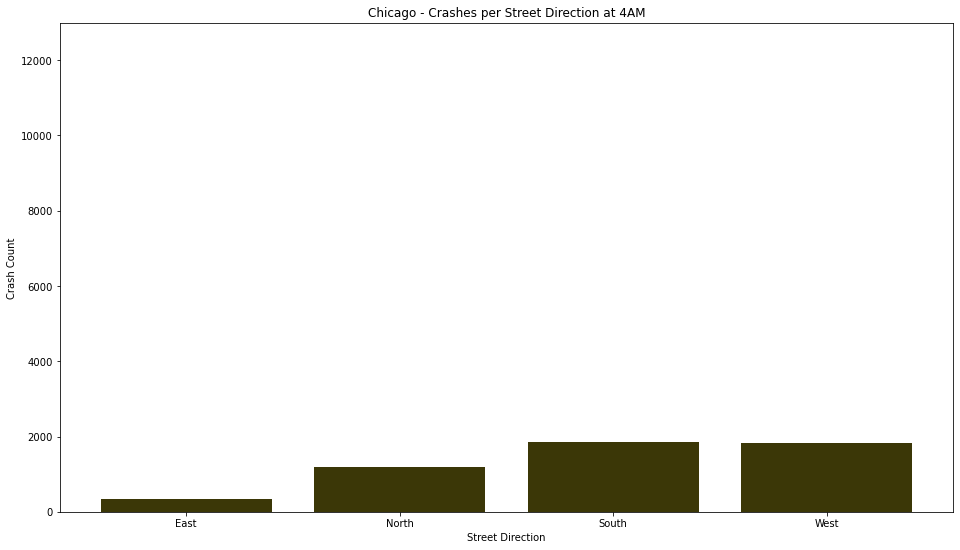

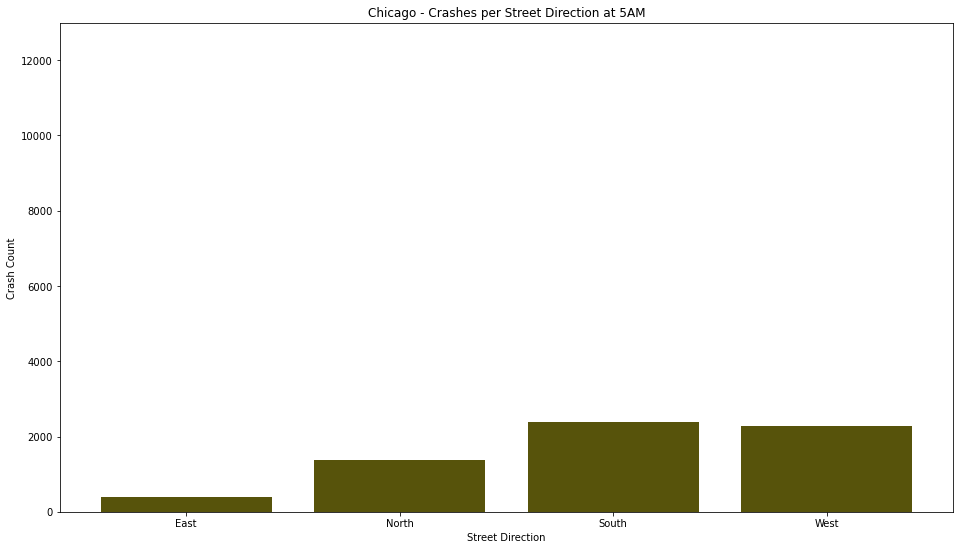

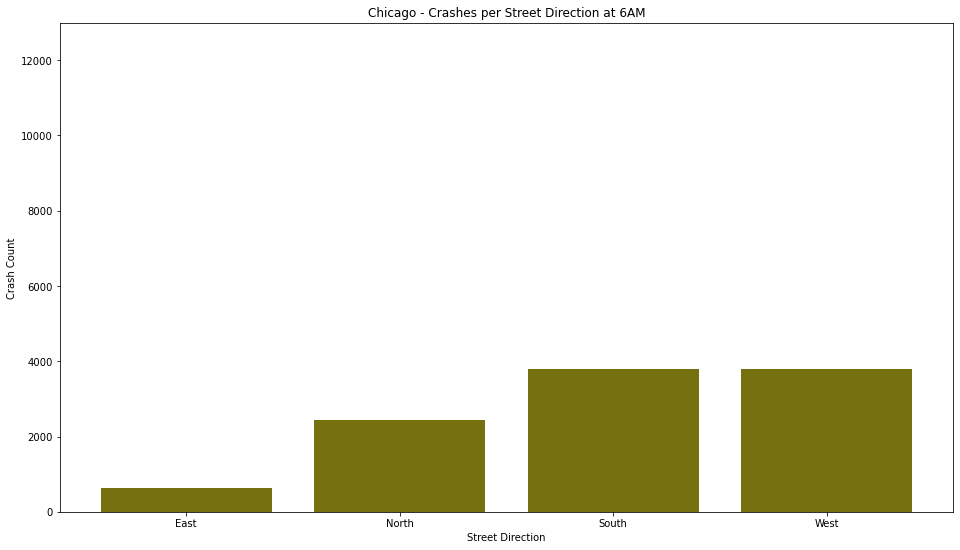

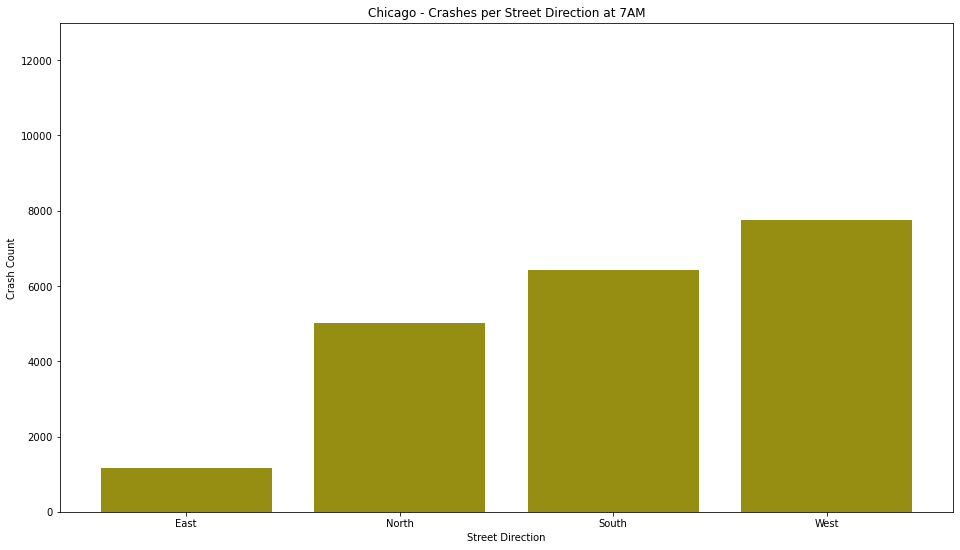

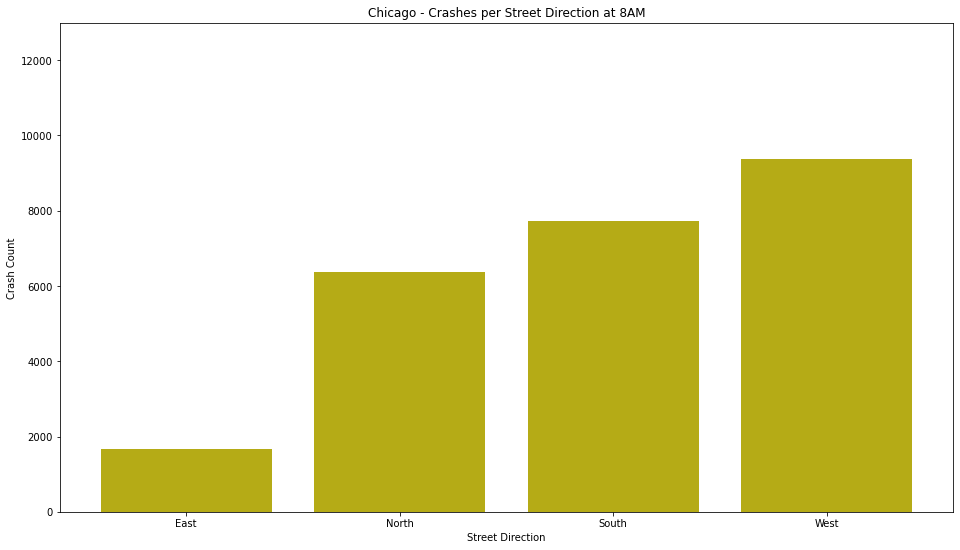

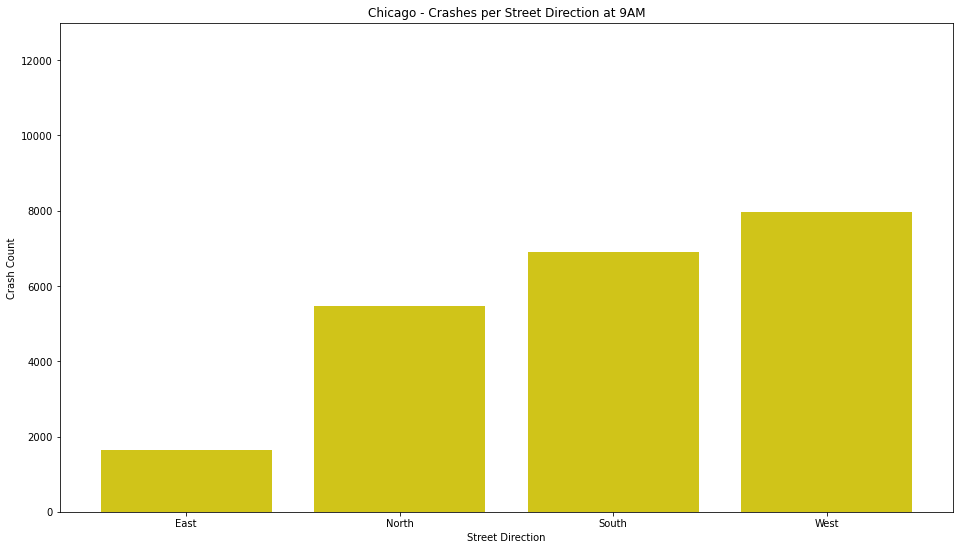

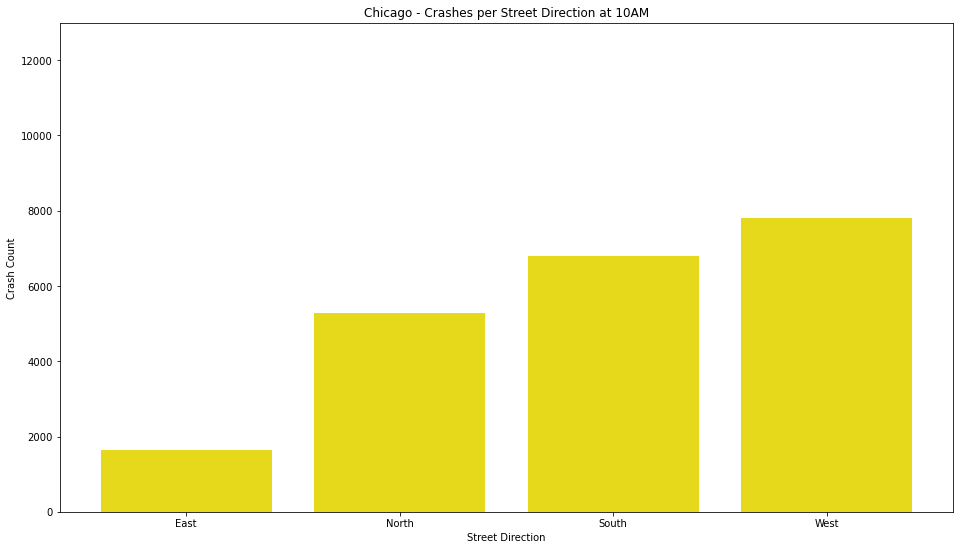

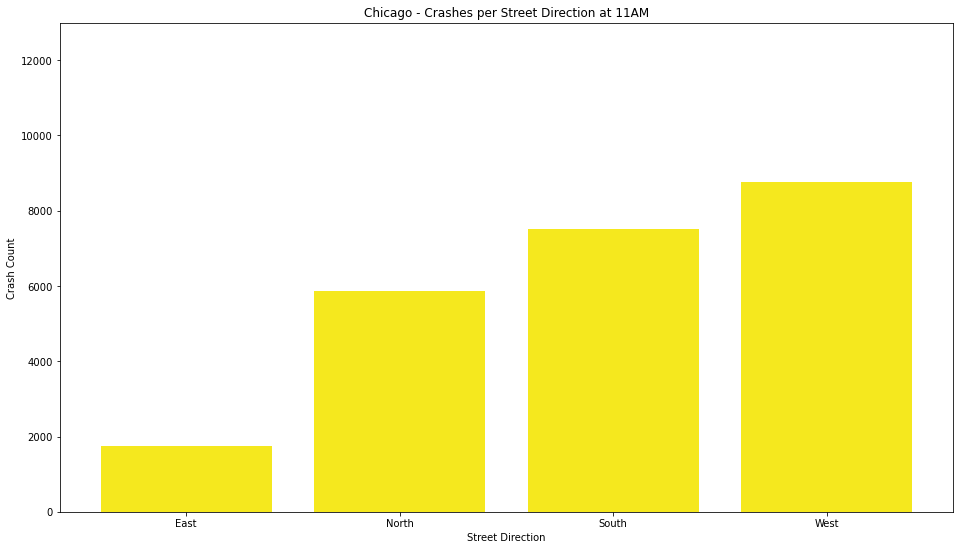

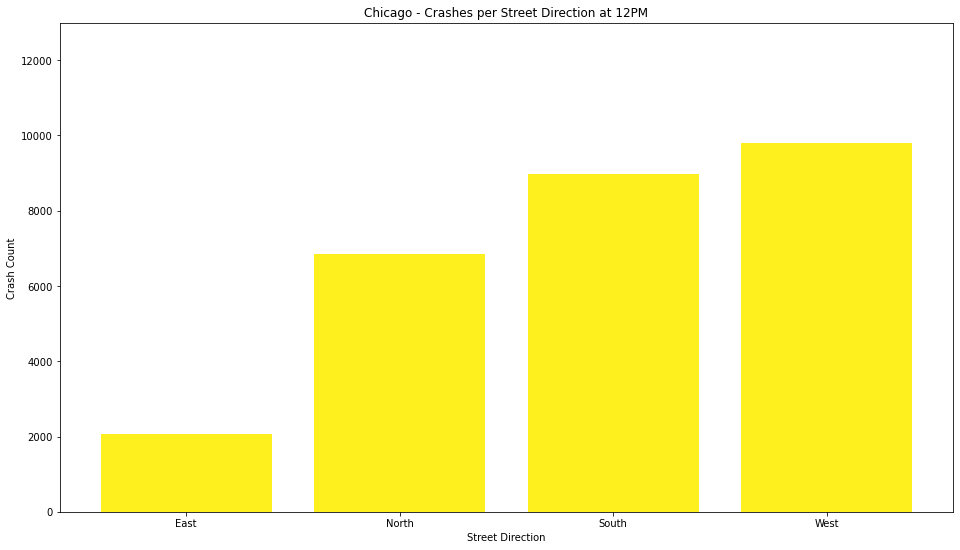

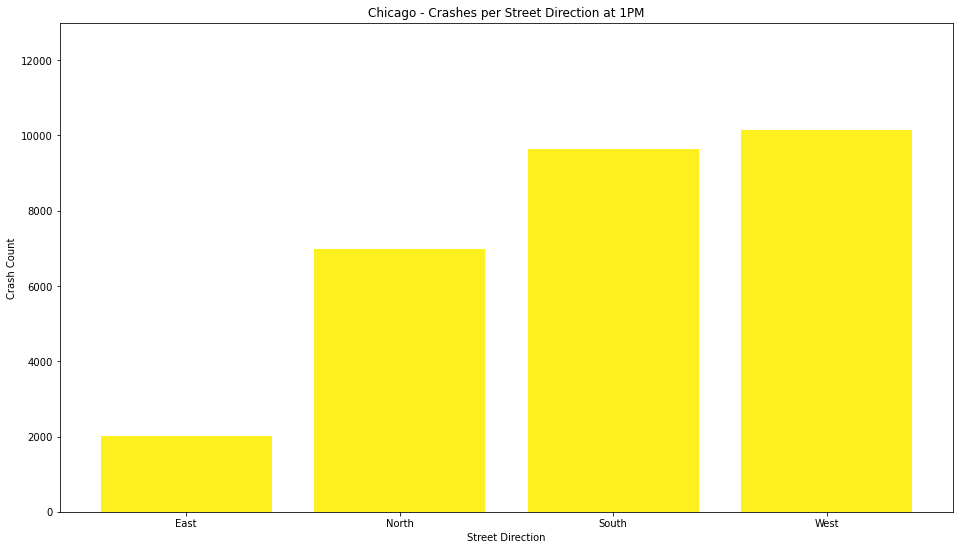

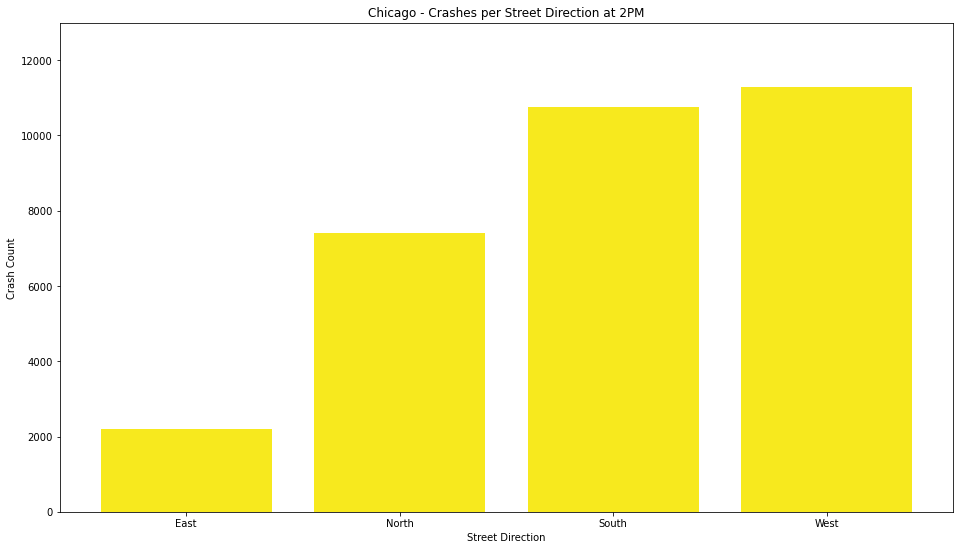

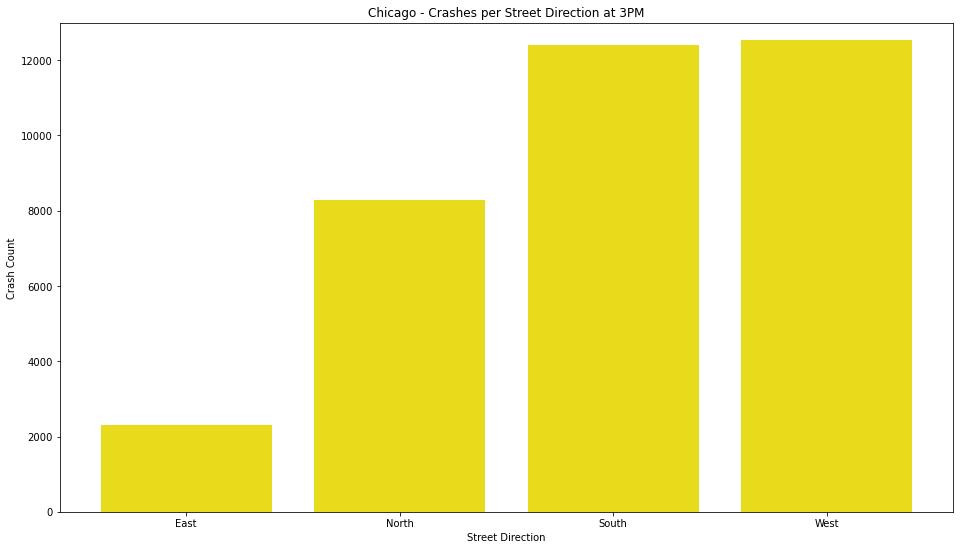

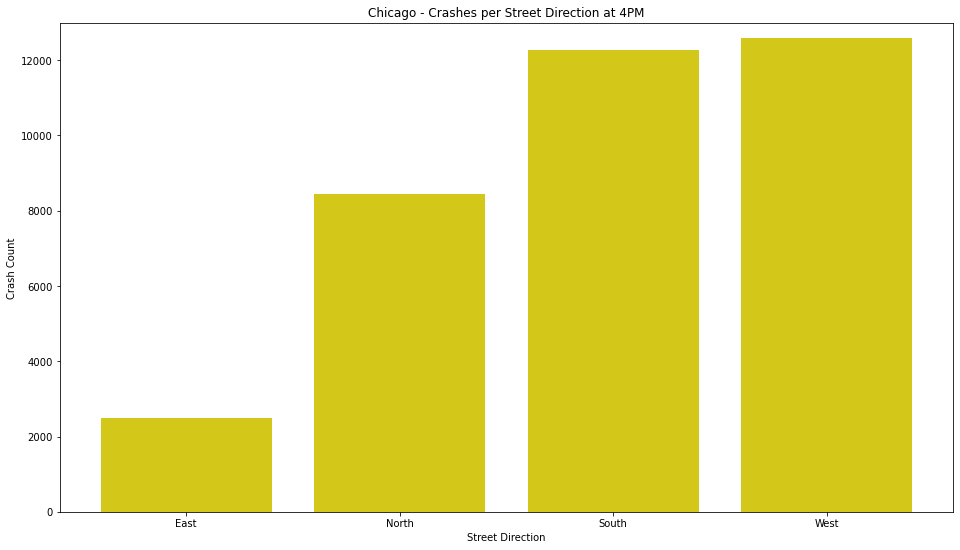

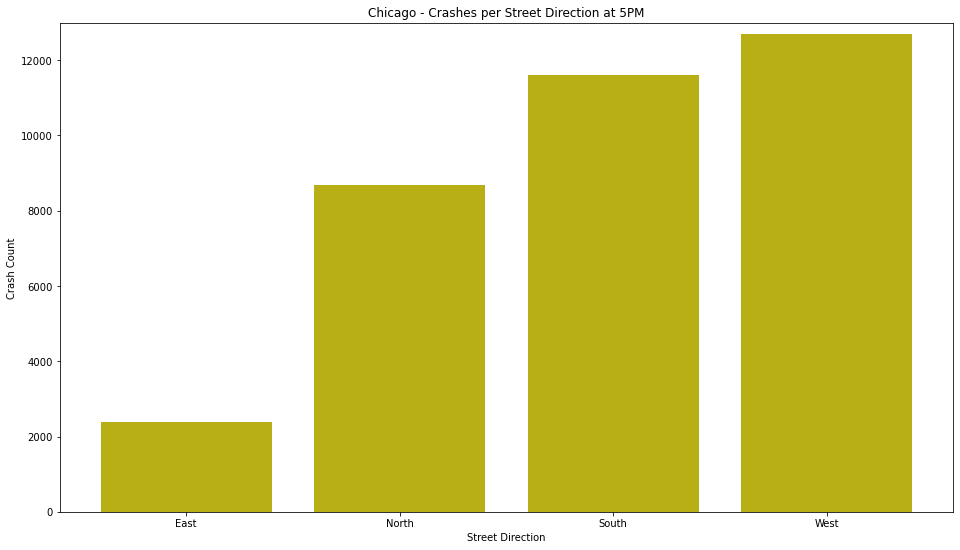

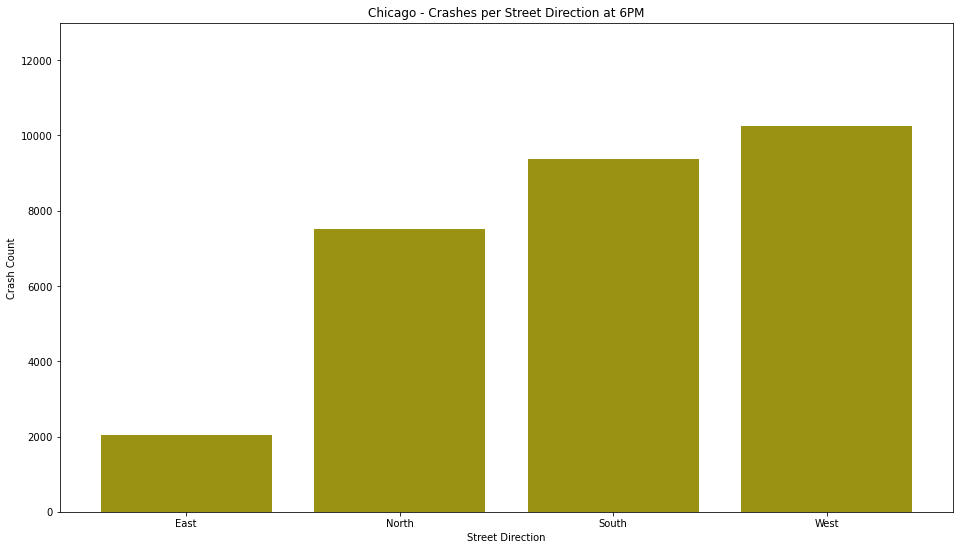

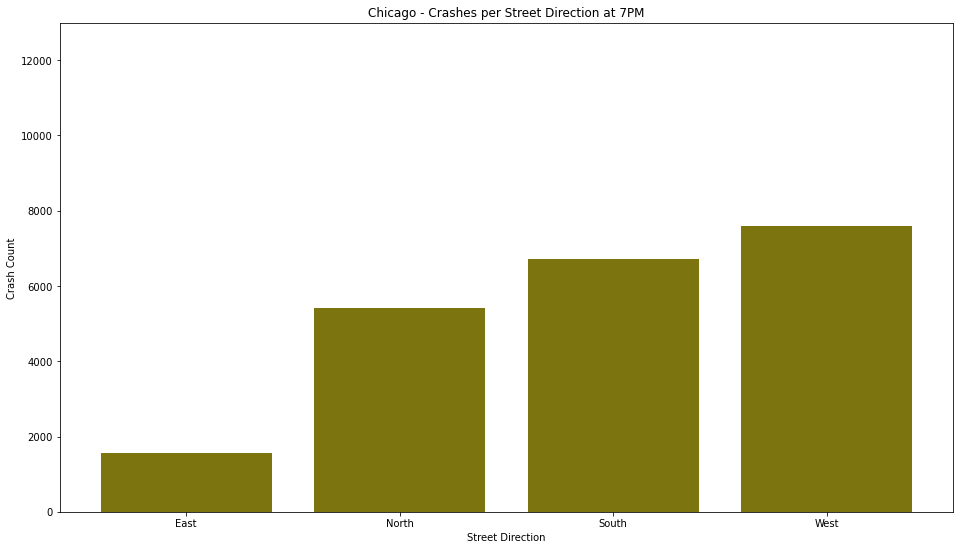

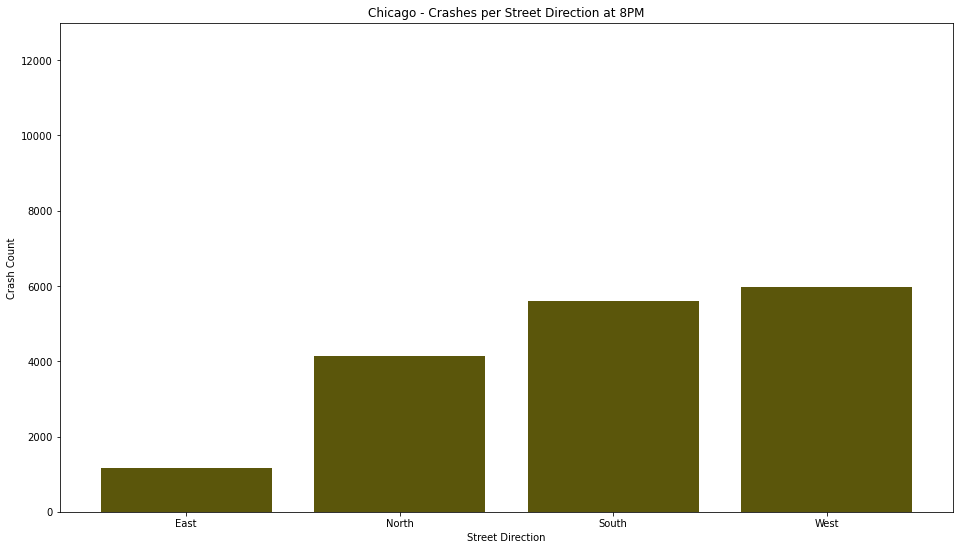

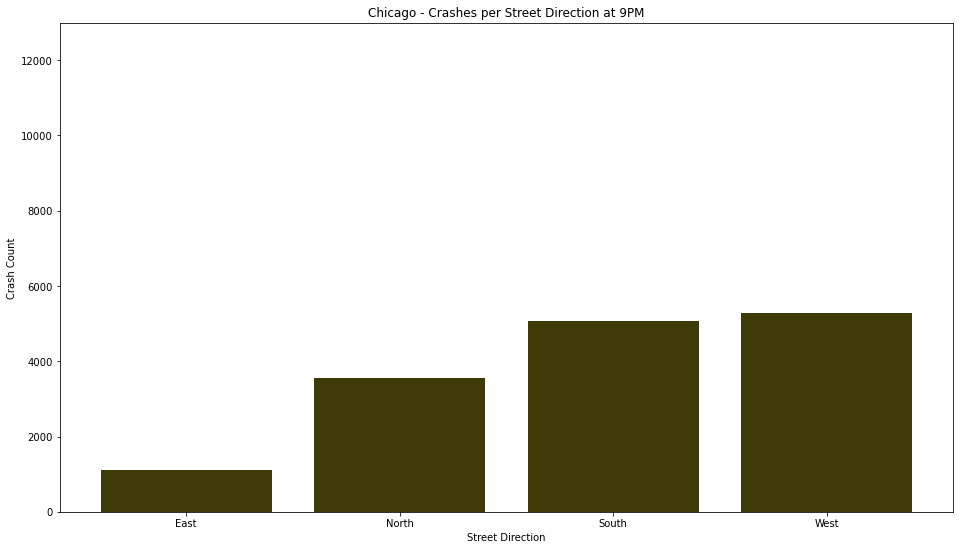

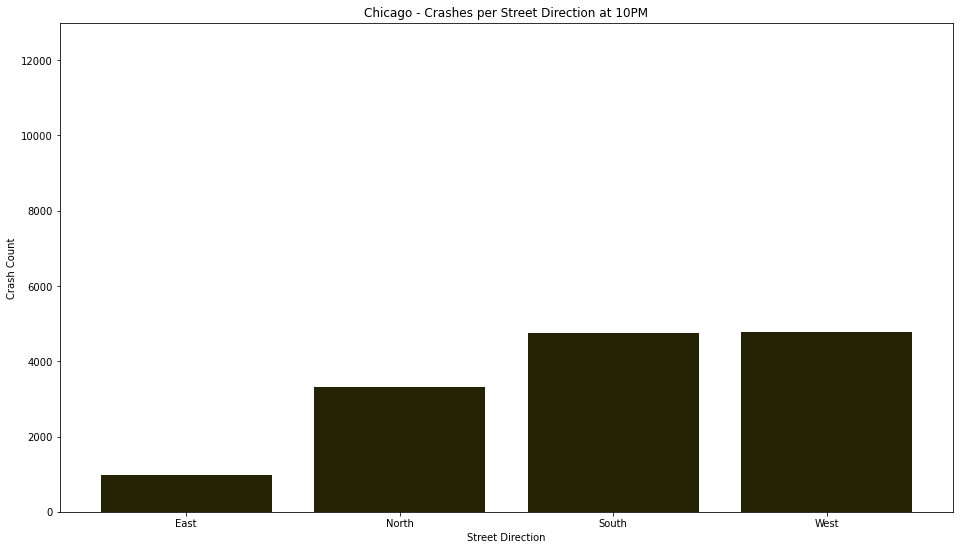

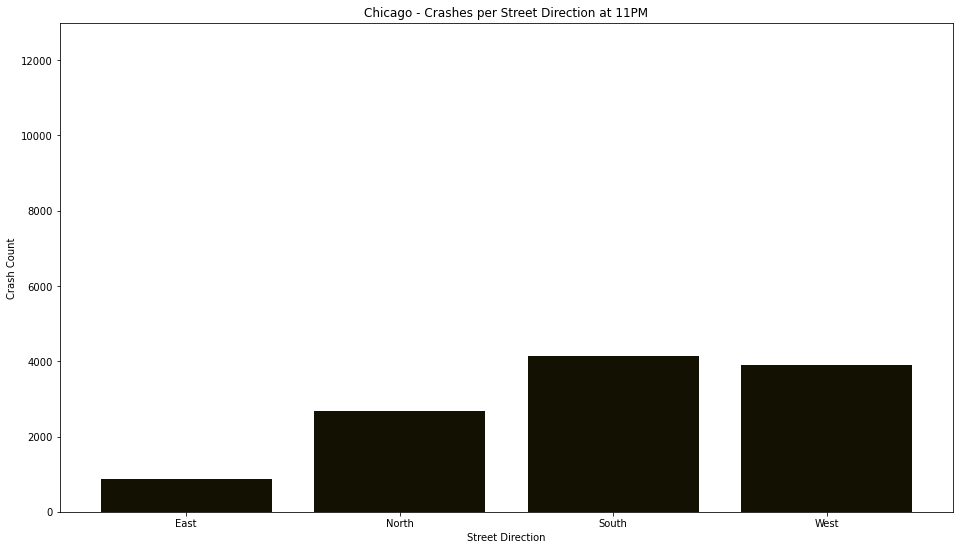

In [72]:
imageio.mimsave('output_data/directionovertime.gif', [plotDirectionsOverTime(crash_df, i) for i in range(24)], fps=1)